## Урок 10. Дисперсионный анализ

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import shapiro, bartlett, f_oneway
from statsmodels.api import stats

%config InlineBackend.figure_format = 'retina'

### Задача 1

Провести дисперсионный анализ для определения того, есть ли различия среднего роста среди взрослых футболистов, хоккеистов и штангистов.

Даны значения роста в трех группах случайно выбранных спортсменов:
- Футболисты: 173, 175, 180, 178, 177, 185, 183, 182.
- Хоккеисты: 177, 179, 180, 188, 177, 172, 171, 184, 180.
- Штангисты: 172, 173, 169, 177, 166, 180, 178, 177, 172, 166, 170.

Попробуем посмотреть на эти цифры:

In [2]:
fb = np.array([173, 175, 180, 178, 177, 185, 183, 182])
hk = np.array([177, 179, 180, 188, 177, 172, 171, 184, 180])
bb = np.array([172, 173, 169, 177, 166, 180, 178, 177, 172, 166, 170])

means = np.array([fb.mean(), hk.mean(), bb.mean()])

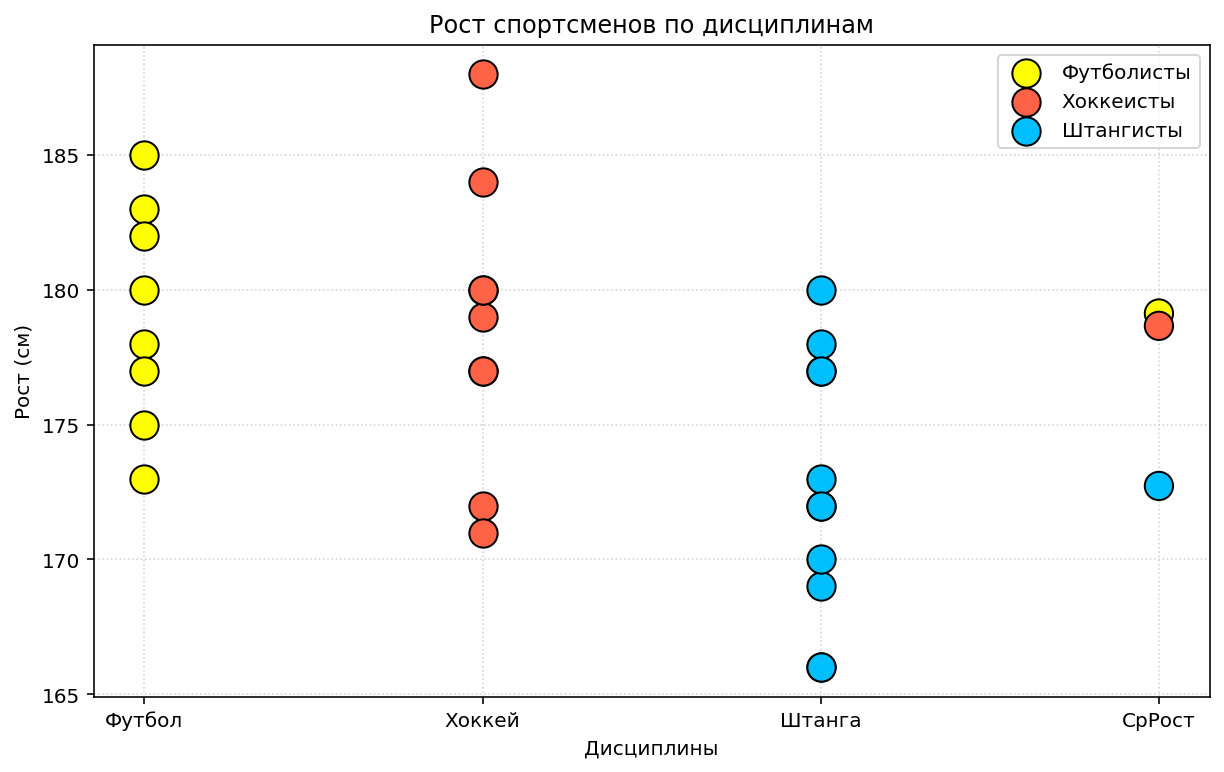

In [3]:
fig, ax = plt.subplots(figsize=(10,6))

colors = ['yellow', 'tomato', 'deepskyblue']

ax.scatter([1]*fb.shape[0], fb, s=200, c=colors[0], edgecolor='black', label='Футболисты')
ax.scatter([2]*hk.shape[0], hk, s=200, c=colors[1], edgecolor='black', label='Хоккеисты')
ax.scatter([3]*bb.shape[0], bb, s=200, c=colors[2], edgecolor='black', label='Штангисты')
ax.scatter([4]*means.shape[0], means, s=200, c=colors, edgecolor='black')
ax.set_xticks(range(1, 5))
ax.set_xticklabels(['Футбол', 'Хоккей', 'Штанга', 'СрРост'])
ax.legend()
ax.grid(ls=':', color='lightgray')
ax.set_axisbelow(True)
ax.set_xlabel('Дисциплины')
ax.set_ylabel('Рост (см)')
ax.set_title('Рост спортсменов по дисциплинам');

Интересно 🙂.

Ладно, что у нас есть?
1. Во всех трех группах разное количество участников
2. Нам неизвестны параметры распределения (нормальность и однородность дисперсий)

Начнем с нормальности и проведем тест Шапиро-Уилка:

In [4]:
shapiro(fb)

ShapiroResult(statistic=0.9775081276893616, pvalue=0.9495397210121155)

In [5]:
shapiro(hk)

ShapiroResult(statistic=0.9579195976257324, pvalue=0.7763133645057678)

In [6]:
shapiro(bb)

ShapiroResult(statistic=0.93868088722229, pvalue=0.5051169991493225)

P-value превышает все разумные пределы уровня значимости, значит - предполагаем нормальность распределения.

Теперь проверим равенство дисперсий:

In [7]:
bartlett(fb, hk, bb)

BartlettResult(statistic=0.4640521043406442, pvalue=0.7929254656083131)

Дисперсии - тоже равны, значит можем использовать критерий Фишера для решения задачи.

Сформулируем гипотезы:

$H_0: \mu_{fb} = \mu_{hk} = \mu_{bb}$

$H_1: \mu_{ХотяБыОднойИзНих} \neq \mu_{Других}$

И определимся с уровнем значимости:

$\alpha = 0.05$

In [8]:
alpha = 0.05
f_oneway(fb, hk, bb)

F_onewayResult(statistic=5.500053450812596, pvalue=0.010482206918698694)

Wow - если бы взяли $\alpha = 0.01$ оснований отвергнуть нулевую гипотезу небыло бы. Но в данном случае - отвергаем $H_0$.

Проверим, что же там не сходится с помощью Критерия Тьюке:

In [9]:
df = pd.DataFrame()

In [10]:
for i, j in zip([fb, hk, bb], ['Футболисты', 'Хоккеисты', 'Штангисты']):
    tmp = pd.DataFrame({'score': i})
    tmp['group'] = j
    df = pd.concat([df, tmp])

df.sample(5)

,score,group
3,188,Хоккеисты
2,180,Футболисты
2,169,Штангисты
1,179,Хоккеисты
6,178,Штангисты


In [11]:
result = stats.multicomp.pairwise_tukeyhsd(endog=df['score'], groups=df['group'], alpha=0.05)
print(result)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2  meandiff p-adj   lower    upper  reject
------------------------------------------------------------
Футболисты Хоккеисты  -0.4583  0.979  -6.2732  5.3566  False
Футболисты Штангисты  -6.3977 0.0219 -11.9583 -0.8372   True
 Хоккеисты Штангисты  -5.9394 0.0284 -11.3181 -0.5607   True
------------------------------------------------------------


Естественно, группа, которая вызвала отклонение $H_0$ об отсутствии разницы в росте - Штангисты (чего мы и наблюдали на первом графике)